<a href="https://colab.research.google.com/github/msvasan1987/HR-Hackathon/blob/main/HR_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [236]:
train = pd.read_csv("train_LZdllcl.csv")
test = pd.read_csv("test_2umaH9m.csv")
submission = pd.read_csv("sample_submission_M0L0uXE.csv")

In [237]:
X = train.drop(columns=["employee_id", "is_promoted"])
y = train["is_promoted"]

X_test = test.drop(columns=["employee_id"])


In [238]:
train.shape

(54808, 14)

In [239]:
test.shape

(23490, 13)

In [240]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [241]:
missing_counts = train.isna().sum()

# Filter columns where NA count > 0
columns_with_na = missing_counts[missing_counts > 0]

# Display result
print(columns_with_na)

education               2409
previous_year_rating    4124
dtype: int64


In [242]:
submission_N = submission

In [243]:
submission['is_promoted'] ='0'

In [244]:
submission_Y = submission

In [245]:
submission_Y.to_csv('submission_N.csv', index = False)

In [246]:
# ------------------------------
# Basic EDA
# ------------------------------
print("\n🔹 Missing Values")
print(train.isnull().sum())


🔹 Missing Values
employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64


In [247]:
print("\n🔹 Promoted Distribution")
print(train['is_promoted'].value_counts())


🔹 Promoted Distribution
is_promoted
0    50140
1     4668
Name: count, dtype: int64


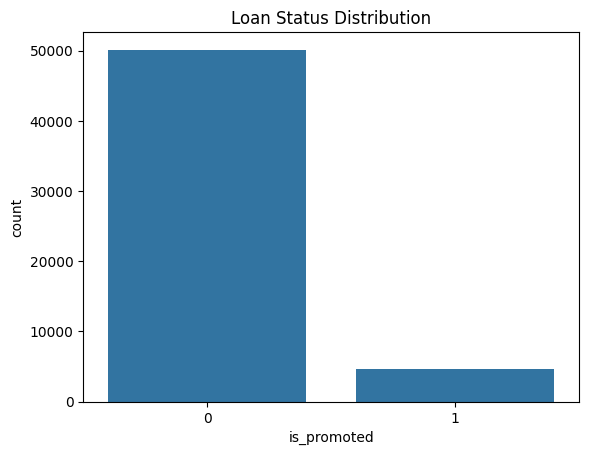

In [248]:
sns.countplot(x='is_promoted', data=train)
plt.title("Loan Status Distribution")
plt.show()


In [249]:
# All promoted employees
promoted_df = train[train["is_promoted"] == 1]

# Check how many
print(promoted_df.shape)

# View first few rows
promoted_df.head()


(4668, 14)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
11,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1
39,58304,Sales & Marketing,region_28,Bachelor's,m,sourcing,1,33,5.0,6,1,0,51,1
60,17673,Sales & Marketing,region_4,Master's & above,m,other,1,50,4.0,17,1,0,47,1
66,77981,Finance,region_22,Bachelor's,m,other,1,27,NaN,1,1,1,58,1
67,16502,Sales & Marketing,region_22,Bachelor's,m,sourcing,1,27,NaN,1,0,0,61,1


In [250]:
train.groupby("is_promoted").mean(numeric_only=True)


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
is_promoted,,,,,,,,
0,39187.520423,1.257639,34.844037,3.267911,5.879398,0.319685,0.014180,62.647686
1,39285.092331,1.203299,34.372965,3.986140,5.716367,0.698800,0.119751,71.325193


In [251]:
# ------------------------------
# Feature Selection
# ------------------------------
train["high_training_score"] = (train["avg_training_score"] >= 71).astype(int)
train["high_rating"] = (train["previous_year_rating"] >= 4.5).astype(int)
train["kpimet"] = (train["KPIs_met >80%"]  >= 0.5).astype(int)


In [252]:
train.groupby("is_promoted").mean(numeric_only=True)

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,high_training_score,high_rating,kpimet
is_promoted,,,,,,,,,,,
0,39187.520423,1.257639,34.844037,3.267911,5.879398,0.319685,0.014180,62.647686,0.287655,0.195852,0.319685
1,39285.092331,1.203299,34.372965,3.986140,5.716367,0.698800,0.119751,71.325193,0.511782,0.411525,0.698800


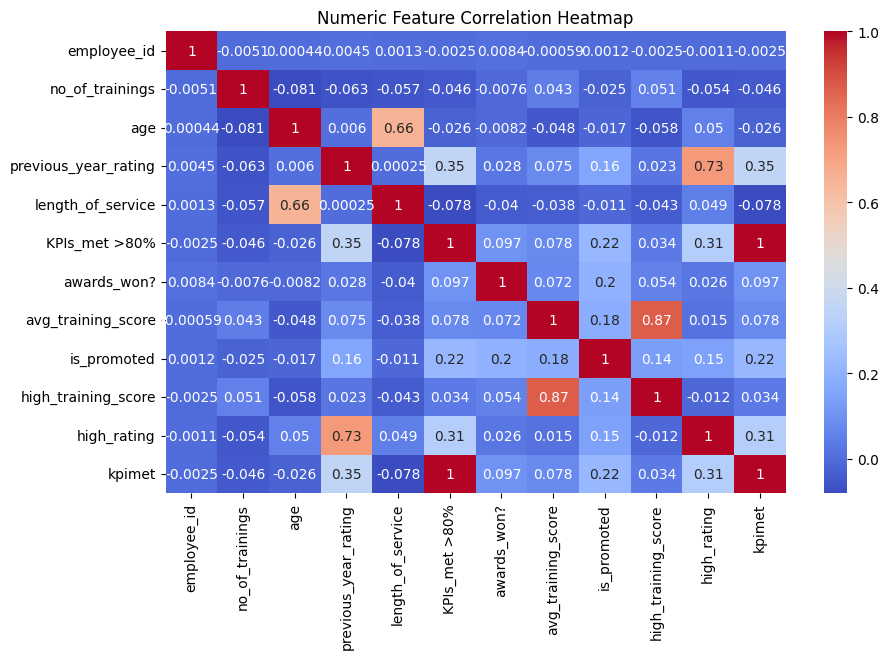

In [253]:
# Correlation heatmap (numeric features) Pearson Coefficent
num_cols = train.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', annot=True)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

In [254]:
# ------------------------------
# Feature Selection
# ------------------------------
X = train.drop(columns=["employee_id", "is_promoted"])
y = train["is_promoted"]

X_test = test.drop(columns=["employee_id"])

X_test["high_rating"] = (X_test["previous_year_rating"] >= 4).astype(int)
X_test["high_training_score"] = (X_test["avg_training_score"] >= 70).astype(int)
X_test["kpimet"] = X_test["KPIs_met >80%"] * X_test["awards_won?"]


categorical_cols = ['department', 'region', 'education', 'recruitment_channel']
numeric_cols = ['high_training_score', 'high_rating', 'kpimet', 'avg_training_score','length_of_service','previous_year_rating','age']

print("\nCategorical Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)


Categorical Columns: ['department', 'region', 'education', 'recruitment_channel']
Numeric Columns: ['high_training_score', 'high_rating', 'kpimet', 'avg_training_score', 'length_of_service', 'previous_year_rating', 'age']


In [255]:
# ------------------------------
# Preprocessing Pipeline
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [256]:
# ------------------------------
# Split Train / Validation
# ------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [257]:
# ------------------------------
# Logistic Regression Model
# ------------------------------
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight='balanced',
    solver='liblinear'
))

])

log_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['high_training_score',
                                                   'high_rating', 'kpimet',
                                                   'avg_training_score',
                                                   'length_of_service',
                                                   'previous_year_rating',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['department', 'region',
                                                   'education',
                                                   'recruitment_channel'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [258]:
# ------------------------------
# Model Evaluation
# ------------------------------
y_pred = log_model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("\n🎯 Validation Accuracy:", acc)

print("\n📌 Classification Report")
print(classification_report(y_val, y_pred))

print("\n📌 Confusion Matrix")
print(confusion_matrix(y_val, y_pred))

# ------------------------------
# Final Training on Full Data
# ------------------------------
log_model.fit(X, y)

# ------------------------------
# Predict Test Set
# ------------------------------


test_predictions = log_model.predict(X_test)






🎯 Validation Accuracy: 0.7635467980295566

📌 Classification Report
              precision    recall  f1-score   support

           0       0.98      0.76      0.85     10028
           1       0.24      0.82      0.37       934

    accuracy                           0.76     10962
   macro avg       0.61      0.79      0.61     10962
weighted avg       0.92      0.76      0.81     10962


📌 Confusion Matrix
[[7603 2425]
 [ 167  767]]


In [260]:
submission = pd.DataFrame({
    "employee_id": test["employee_id"],
    "is_promoted": test_predictions
})

submission.to_csv("submission_final.csv", index=False)


In [262]:
import joblib

joblib.dump(log_model,'hr_promotion_pred_model.pkl')

['hr_promotion_pred_model.pkl']